# Part 2 begins here

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, BatchNormalization, Reshape

tfb = tfp.bijectors
tfd = tfp.distributions
tfpl = tfp.layers

%matplotlib inline

In [2]:
# Set up plotting data

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])
print(inputs.shape)

(100, 100, 2)


In [3]:
# Helper function to compute transformed distribution densities

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a 
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

In [4]:
# Helper function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot

In [5]:
def transform_distribution(distribution, alpha, theta):
    # treat alpha as a scale factor
    bijector = tfb.Scale(alpha)
    
    return tfd.TransformedDistribution(
        distribution,
        bijector
    )

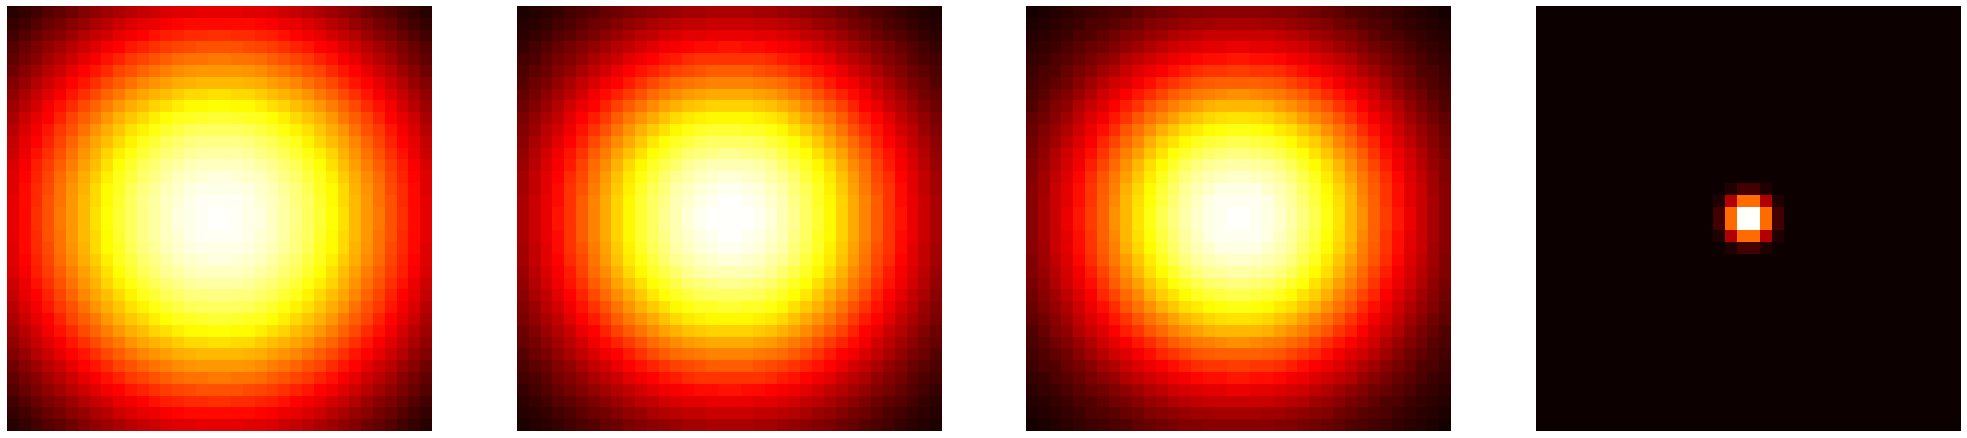

In [6]:
from IPython.display import Image, display

base_distribution = tfd.MultivariateNormalDiag(loc=[[0,0]], scale_diag=[[0.3,0.3]])

theta_distribution = tfd.Uniform(low=0.0, high=2*math.pi)
alpha_distribution = tfd.Normal(loc=0.0, scale=3.0)

fig, ax = plt.subplots(1, 4, figsize=(35, 35))

for i in range(4):
    alpha = alpha_distribution.sample()
    theta = theta_distribution.sample()
    transformed_distribution = transform_distribution(base_distribution, alpha, theta)
    
    densities = get_densities(transformed_distribution)
    density = densities[0]

    image = get_image_array_from_density_values(density)

    ax[i].imshow(image)
    ax[i].axis("off")
    
plt.show()

In [7]:
# Build the dataset
dataset_images = []
num_images = 300

for i in range(num_images):
    alpha = alpha_distribution.sample()
    theta = theta_distribution.sample()
    transformed_distribution = transform_distribution(base_distribution, alpha, theta)
    
    densities = get_densities(transformed_distribution)
    density = densities[0]

    image = get_image_array_from_density_values(density)
    
    dataset_images.append(image)

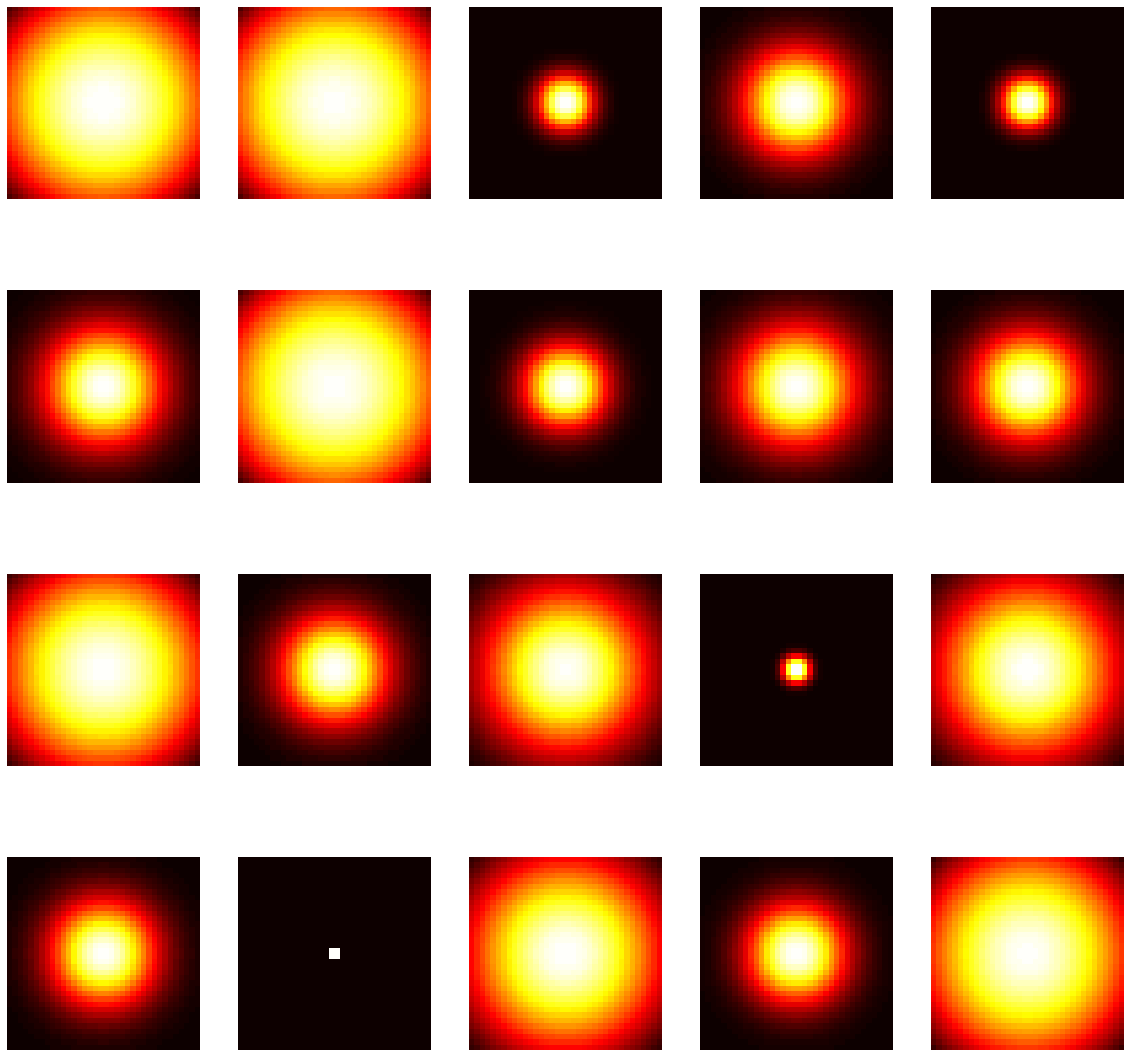

In [8]:
# Display a sample of 20 images from your generated dataset in a figure

from numpy.random import default_rng
rng = default_rng()

fig, axs = plt.subplots(4, 5, figsize=(20, 20))

for k in range(20):
    i = k // 5
    j = k % 5
    
    index = rng.integers(low=0, high=num_images)
    axs[i, j].imshow(dataset_images[index])
    axs[i, j].axis('off')
    
plt.show()

# Part 3 begins here

## 3. Make `tf.data.Dataset` objects
* You should now split your dataset to create `tf.data.Dataset` objects for training and validation data. 
* Using the `map` method, normalise the pixel values so that they lie between 0 and 1.
* These Datasets will be used to train a variational autoencoder (VAE). Use the `map` method to return a tuple of input and output Tensors where the image is duplicated as both input and output.
* Randomly shuffle the training Dataset.
* Batch both datasets with a batch size of 20, setting `drop_remainder=True`.
* Print the `element_spec` property for one of the Dataset objects.

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_images)

train_size = int(0.80 * num_images)
validate_size = int(0.10 * num_images)
test_size = int(0.10 * num_images)

In [10]:
def normalize_image(image):
    normalized_image = tf.cast(image, tf.float32) / 255.
    return (normalized_image, normalized_image)

dataset = dataset.map(normalize_image)

train_dataset = dataset.take(train_size)
validate_dataset = dataset.skip(train_size).take(validate_size)
test_dataset = dataset.skip(train_size + validate_size)

In [11]:
train_dataset = train_dataset.shuffle(buffer_size=num_images)

In [12]:
train_dataset = train_dataset.batch(20, drop_remainder=True)
validate_dataset = validate_dataset.batch(20, drop_remainder=True)
test_dataset = test_dataset.batch(20, drop_remainder=True)

print(train_dataset.element_spec)

(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))


# Part four begins here

In [13]:
latent_dim = 50

prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim))

In [14]:
def get_kl_regularizer(prior_distribution):
    """
    This function should create an instance of the KLDivergenceRegularizer 
    according to the above specification. 
    The function takes the prior_distribution, which should be used to define 
    the distribution.
    Your function should then return the KLDivergenceRegularizer instance.
    """
    return tfpl.KLDivergenceRegularizer(prior_distribution,
                                        weight=1.0,
                                        use_exact_kl=False,
                                        test_points_fn=lambda q: q.sample(3),
                                        test_points_reduce_axis=None) 

In [15]:
kl_regularizer = get_kl_regularizer(prior)

In [16]:
encoder = Sequential([
    Conv2D(filters=32, padding='SAME', kernel_size=(4,4), strides=(2,2), activation='relu', input_shape=(36,36,3)),
    BatchNormalization(),
    Conv2D(filters=64, padding='SAME', kernel_size=(4,4), strides=(2,2), activation='relu'),
    BatchNormalization(),
    Conv2D(filters=128, padding='SAME', kernel_size=(4,4), strides=(2,2), activation='relu'),
    BatchNormalization(),
    Conv2D(filters=256, padding='SAME', kernel_size=(4,4), strides=(2,2), activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
    tfpl.MultivariateNormalTriL(event_size=latent_dim, activity_regularizer=kl_regularizer)
])
encoder.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 18, 32)        1568      
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 5, 128)         512       
___________________________________

In [18]:
decoder = Sequential([
    Dense(36*36, activation='relu', input_shape=(latent_dim,)),
    Reshape((9,9,16)),
    UpSampling2D(size=(2,2)),
    Conv2D(filters=128, padding='SAME', kernel_size=(3,3), activation='relu'),
    UpSampling2D(size=(2,2)),
    Conv2D(filters=128, padding='SAME', kernel_size=(3,3), activation='relu'),
    Conv2D(filters=3, padding='SAME', kernel_size=(3,3)),
    Flatten(),
    tfpl.IndependentBernoulli(event_shape=(36,36,3))
])
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1296)              66096     
_________________________________________________________________
reshape (Reshape)            (None, 9, 9, 16)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 128)       18560     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 36, 128)       147584    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 36, 3)        

# Part five begins here

In [21]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [22]:
def nll(batch_of_images, decoding_dist):
    return -tf.math.reduce_mean(decoding_dist.log_prob(batch_of_images), 0)

In [23]:
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer, loss=nll)

In [24]:
history = vae.fit(train_dataset, validation_data=validate_dataset, epochs=20, verbose=2)

Epoch 1/20
12/12 - 7s - loss: 2248.6714 - val_loss: 2540.6855
Epoch 2/20
12/12 - 4s - loss: 1452.2262 - val_loss: 2161.5681
Epoch 3/20
12/12 - 3s - loss: 1245.8260 - val_loss: 1843.1617
Epoch 4/20
12/12 - 3s - loss: 1020.7294 - val_loss: 1557.0668
Epoch 5/20
12/12 - 4s - loss: 867.5668 - val_loss: 1381.3408
Epoch 6/20
12/12 - 3s - loss: 844.5623 - val_loss: 1499.6150
Epoch 7/20
12/12 - 4s - loss: 790.6437 - val_loss: 1495.3481
Epoch 8/20
12/12 - 4s - loss: 734.5745 - val_loss: 1321.3566
Epoch 9/20
12/12 - 4s - loss: 721.6288 - val_loss: 1310.8545
Epoch 10/20
12/12 - 4s - loss: 704.4789 - val_loss: 1110.5704
Epoch 11/20
12/12 - 3s - loss: 695.4022 - val_loss: 1037.0392
Epoch 12/20
12/12 - 3s - loss: 680.2296 - val_loss: 1077.9659
Epoch 13/20
12/12 - 3s - loss: 666.0670 - val_loss: 1083.6385
Epoch 14/20
12/12 - 3s - loss: 658.5401 - val_loss: 998.8613
Epoch 15/20
12/12 - 3s - loss: 646.1820 - val_loss: 934.0070
Epoch 16/20
12/12 - 3s - loss: 638.6255 - val_loss: 986.1465
Epoch 17/20
12/1

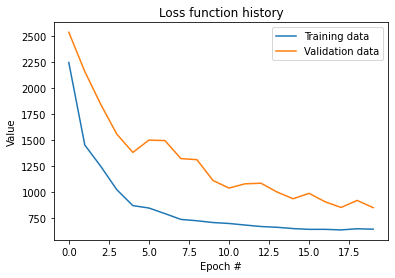

In [25]:
# Plot history:
plt.plot(history.history['loss'], label='Training data')
plt.plot(history.history['val_loss'], label='Validation data')
plt.title('Loss function history')
plt.ylabel('Value')
plt.xlabel('Epoch #')
plt.legend(loc="upper right")
plt.show()

# Part six begins here

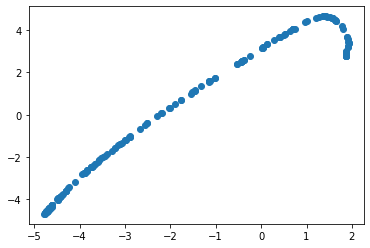

In [46]:
# Randomly sample 1000 images from the dataset, and pass them through the encoder. 
# Display the embeddings in a scatter plot 
#   (project to 2 dimensions if the latent space has dimension higher than two).

N = 200
x_data = []
y_data = []
for i in range(N):
    index = rng.integers(low=0, high=num_images)
    image = dataset_images[index]
    image_plus = tf.expand_dims(image, axis=0)
    normalized_image = tf.cast(image_plus, tf.float32) / 255.
    r = encoder(normalized_image).mean().numpy()
    #print(r)
    x = r[0][0]
    y = r[0][1]
    x_data.append(x)
    y_data.append(y)

plt.scatter(x_data, y_data)
plt.show()

230
281
78
25


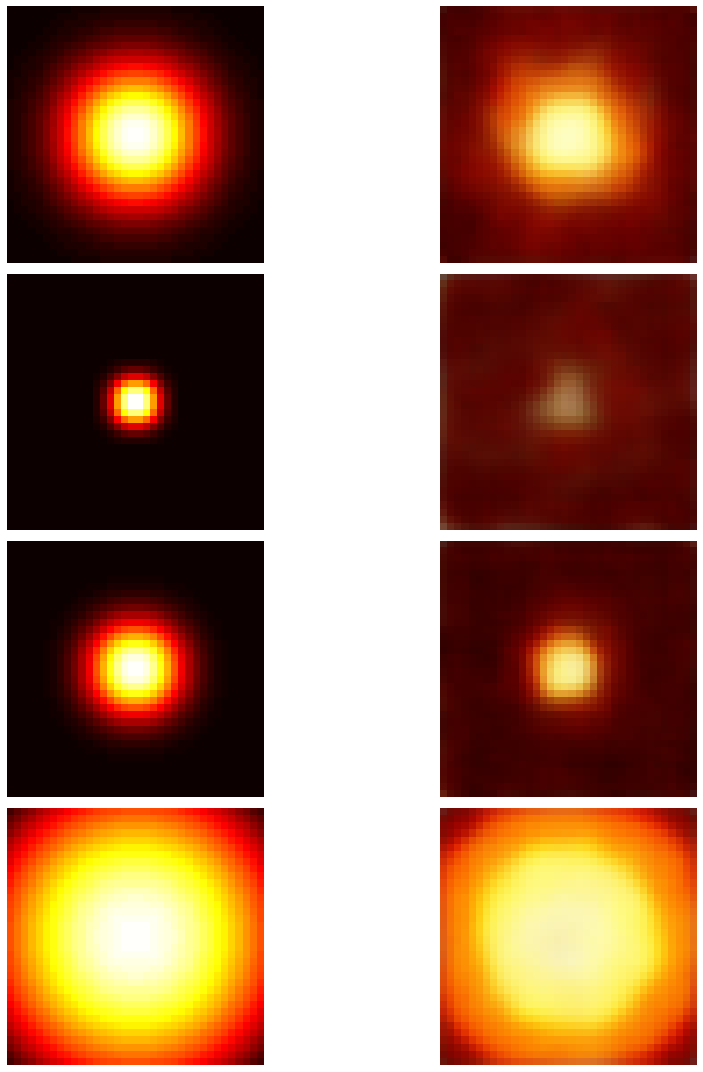

In [34]:
# Randomly sample 4 images from the dataset and for each image, 
#   display the original and reconstructed image from the VAE in a figure.

fig, axs = plt.subplots(4, 2, figsize=(15, 15))

for i in range(4):
    index = rng.integers(low=0, high=num_images)
    image = dataset_images[index]
    image_plus = tf.expand_dims(image, axis=0)
    normalized_image = tf.cast(image_plus, tf.float32) / 255.
    result = vae(normalized_image).mean().numpy().squeeze()
    
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    axs[i, 1].imshow(result)
    axs[i, 1].axis('off')
    
plt.tight_layout()
plt.show()

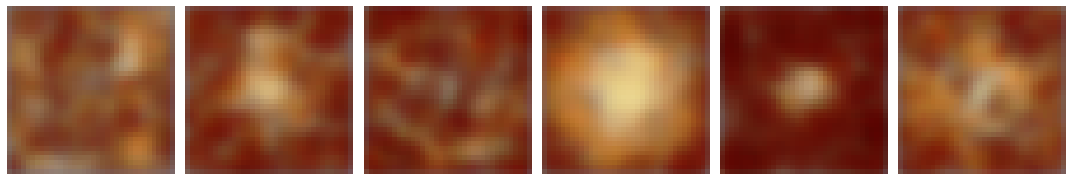

In [41]:
# Randomly sample 6 latent variable realisations from the prior distribution, and display the images in a figure.

fig, axs = plt.subplots(1, 6, figsize=(15, 5))

for i in range(6):
    sample = prior.sample()
    
    sample_plus = tf.expand_dims(sample, axis=0)
    viz = decoder(sample_plus).mean().numpy().squeeze()
    
    axs[i].imshow(viz)
    axs[i].axis('off')
    
plt.tight_layout()
plt.show()